
import sys

print(sys.executable)

### Import Libraries

In [3]:
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import top_k_categorical_accuracy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
import itertools

# Set data format
K.set_image_data_format('channels_first')
print(K.backend(), K.image_data_format())


tensorflow channels_first


### Define Parameters

In [4]:
batch_size = 128
samples_per_epoch = 10
num_classes = 5
epochs = 40
class_names = ["voip", "video", "file transfer", "chat", "browsing"]

height, width = 1500, 1500
input_shape = (1500, 1500, 1)  # NHWC


MODEL_NAME = "overlap_multiclass_reg_non_bn"
PATH_PREFIX = "datasets/"
dataset_file = os.path.join(PATH_PREFIX, "file_vs_all_reg.npz")
dataset = np.load(dataset_file)

x_train = dataset['x_train']
y_train_true = dataset['y_train']
x_val = dataset['x_val']
y_val_true = dataset['y_val']

x_train = x_train.transpose(0, 2, 3, 1)  # from (samples, 1, H, W) -> (samples, H, W, 1)
x_val = x_val.transpose(0, 2, 3, 1)

print(x_train.shape, y_train_true.shape)
print(x_val.shape, y_val_true.shape)

# Shuffle data
def shuffle_data(x, y):
    s = np.arange(x.shape[0])
    np.random.shuffle(s)
    return x[s], y[s]

x_train, y_train_true = shuffle_data(x_train, y_train_true)

# Convert labels to categorical
y_train = to_categorical(y_train_true, num_classes)
y_val = to_categorical(y_val_true, num_classes)


(1988, 1500, 1500, 1) (1988,)
(221, 1500, 1500, 1) (221,)


### Import Train and Validation Data

In [5]:


# Shuffle data
def shuffle_data(x, y):
    s = np.arange(x.shape[0])
    np.random.shuffle(s)
    return x[s], y[s]

x_train, y_train_true = shuffle_data(x_train, y_train_true)

# Convert labels to categorical
y_train = to_categorical(y_train_true, num_classes)
y_val = to_categorical(y_val_true, num_classes)


### Shuffle Data

In [6]:
def shuffle_data(x, y):
    s = np.arange(x.shape[0])
    np.random.shuffle(s)
    x = x[s]
    y = y[s]
    print (x.shape, y.shape)
    return x, y

x_train, y_train_true = shuffle_data(x_train, y_train_true)

print(y_train_true[0:10])

(1988, 1500, 1500, 1) (1988,)
[1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]


### convert class vectors to binary class matrices

In [7]:
y_train = to_categorical(y_train_true, num_classes)
y_val =to_categorical(y_val_true, num_classes)
print(y_train[0:10])
print (y_val[0:10])
print(y_train.shape, y_val.shape)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
(1988, 5) (221, 5)


### Define and Compile model

In [8]:
def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))


### Define nice_imshow and make_moasic functions

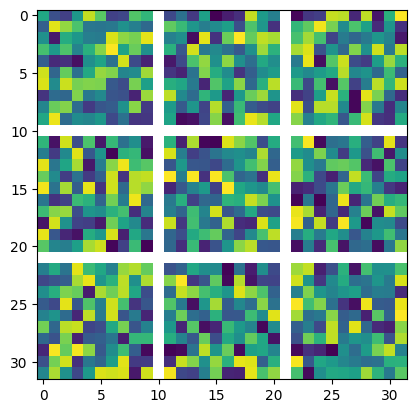

In [9]:
import pylab as pl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None, bar=True):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap,origin='lower')
    if bar:
        cax = divider.append_axes("right", size="5%", pad=0.05)
        pl.colorbar(im, cax=cax)

def plotNNFilter2(data, nrows, ncols, layer_name, cmap=None, bar=True):
    """Wrapper around pl.subplot with color bar"""
    if cmap is None:
        cmap = "gray"
    
    fig, axes = pl.subplots(nrows, ncols,figsize=(5*ncols, 4*nrows))
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(data[:,:,i], interpolation="nearest", cmap=cmap)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.invert_yaxis()

    fig.subplots_adjust(wspace=0.025, hspace=0.05)
    if bar:
        fig.colorbar(im, ax=axes.ravel().tolist())
    
    pl.savefig(MODEL_NAME +  "_plotNNFilter2_" + layer_name, bbox_inches='tight', pad_inches=1)
    pl.show()

def plotNNFilter(data, nrows, ncols, layer_name, cmap=None, bar=True):
    """Wrapper around pl.subplot"""
    if cmap is None:
        cmap = "gray"
    
    pl.figure(figsize=(3*ncols, 3*nrows))
    
    for i in range(nrows*ncols):
        pl.subplot(nrows, ncols, i+1)
        pl.imshow(data[:,:,i], interpolation="nearest", cmap=cmap)
        pl.xticks([])
        pl.yticks([])
        pl.gca().invert_yaxis()
    pl.subplots_adjust(wspace=0.025, hspace=0.05)
    pl.savefig(MODEL_NAME +  "_plotNNFilter_" + layer_name, bbox_inches='tight', pad_inches=1)
    pl.show()
        
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[2]
    imshape = imgs.shape[0:2]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:,:,i]
    return mosaic

def mosaic_imshow(imgs, nrows, ncols, cmap=None, border=1, layer_name="convout"):
    pl.figure(figsize=(3*ncols, 3*nrows))
#     pl.suptitle('convout2')
    nice_imshow(pl.gca(), make_mosaic(imgs, nrows, ncols, border=border), cmap=cmap)
    pl.savefig(MODEL_NAME +  "_mosaic_imshow_" + layer_name, bbox_inches='tight', pad_inches=1)
    pl.show()

pl.imshow(make_mosaic(np.random.random((10, 10, 9)), 3, 3, border=1))
pl.show()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

# Ensure your input shape matches your data
input_shape = (1, 1500, 1500)  # channels_first

model = Sequential([
    Conv2D(10, kernel_size=(10,10), strides=5, padding="same", input_shape=input_shape, name="conv1"),
    Activation('relu', name="relu1"),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(20, kernel_size=(10,10), strides=5, padding="same", name="conv2"),
    Activation('relu', name="relu2"),
    Dropout(0.25),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, activation='relu', name="dense1"),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', name="output")
])


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', top_2_categorical_accuracy, f1_score, precision, recall]
)

model.summary()

# Visualize weights
W1 = model.layers[0].get_weights()[0]
W1 = np.squeeze(W1)
# W1 = np.asarray(W1)
print("W1 shape : ", W1.shape)

mosaic_imshow(W1, 2, 5, cmap=cm.binary, border=1, layer_name="conv1_weights_before")
plotNNFilter(W1, 2, 5, cmap=cm.binary, layer_name="conv1_weights_before")
plotNNFilter2(W1, 2, 5, cmap=cm.binary, layer_name="conv1_weights_before")

# Visualize weights
W2 = model.layers[3].get_weights()[0][:,:,0,:]
W2 = np.asarray(W2)
print("W2 shape : ", W2.shape)

mosaic_imshow(W2, 4, 5, cmap=cm.binary, border=1, layer_name="conv2_weights_before")
plotNNFilter(W2, 4, 5, cmap=cm.binary, layer_name="conv2_weights_before")
plotNNFilter2(W2, 4, 5, cmap=cm.binary, layer_name="conv2_weights_before")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'top_2_categorical_accuracy' is not defined

### Fit model on training data

In [63]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
def generator(features, labels, batch_size):
    num_samples = len(features)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_x = features[offset:offset+batch_size].astype(np.float32)
            batch_y = labels[offset:offset+batch_size].astype(np.float32)
            yield batch_x, batch_y

# Callbacks
tensorboard = TensorBoard(
    log_dir='./Graph',
    histogram_freq=1,
    write_images=True
)

checkpointer_loss = ModelCheckpoint(
    filepath=MODEL_NAME + '_loss.weights.h5',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

checkpointer_acc = ModelCheckpoint(
    monitor='val_accuracy',
    filepath=MODEL_NAME + '_acc.weights.h5',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

# Train the model
history = model.fit(
    generator(x_train, y_train, batch_size),
    steps_per_epoch=len(x_train)//batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard, checkpointer_loss, checkpointer_acc],
    validation_data=(x_val.astype(np.float32), y_val.astype(np.float32))
)


Epoch 1/40


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv1" is incompatible with the layer: expected axis 1 of input shape to have value 1, but received input with shape (None, 1500, 1500, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 1500, 1500, 1), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

### Plot history accuracy

In [8]:
import matplotlib.pyplot as plt
import pickle

with open(MODEL_NAME +  "_accuracy.pkl", 'wb') as output:
    pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)

# list all data in history
print(history.history.keys())
x = np.asarray(range(1,epochs + 1))
# summarize history for accuracy
plt.figure()
plt.plot(x, history.history['acc'])
plt.plot(x, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(MODEL_NAME +  " accuracy history", bbox_inches='tight', pad_inches=1)
plt.show()

NameError: name 'MODEL_NAME' is not defined

### Plot Confusion Matrix

In [9]:
y_val_prediction = model.predict_classes(x_val, verbose=1)

NameError: name 'model' is not defined

In [10]:
print(y_val_prediction[:10])

NameError: name 'y_val_prediction' is not defined

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(fname, bbox_inches='tight', pad_inches=1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val_true, y_val_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix',
                      fname=MODEL_NAME + "_" + 'Normalized_confusion_matrix')

plt.show()

NameError: name 'y_val_true' is not defined

In [ ]:
def stats(y_true, y_pred):
    correct = sum([1 for i,pred in enumerate(y_pred) if y_true[i][pred]==1])
    print(y_true.shape[0], correct, correct*1.0/len(y_true))
    
    for class_ind in range(y_true.shape[1]):
        total_ind = len([1 for val in y_true if val[class_ind]==1])
        correct_ind = sum([1 for i,pred in enumerate(y_pred) if (pred == class_ind and y_true[i][pred]==1)])
        print(class_ind, total_ind, correct_ind, correct_ind*1.0/total_ind)

stats(y_val, y_val_prediction)
# stats(y_test_vpn, y_test_vpn_prediction)
# stats(y_test_tor, y_test_tor_prediction)
# correct_1 = sum([1 for i,pred in enumerate(y_test_prediction) if (pred == 1 and y_test[i][pred]==1)])
# print correct_1, correct_1*1.0/len([1 for val in y_test if val[1]==1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val_true, y_val_prediction))

In [ ]:
# Visualize the first layer of convolutions on an input image
X = x_train[i][0]
print(X)
print(y_train_true[i])
pl.figure(figsize=(15, 15))
nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.binary)
pl.savefig(MODEL_NAME +  "_input_" + str(int(y_train_true[i])), bbox_inches='tight', pad_inches=1)
pl.show()

# Visualize convolution result (after activation)
def get_layer_output(layer, input_img, layer_name):
    convout_f = K.function(model.inputs, [layer.output])
    C = convout_f([input_img])
    C = np.squeeze(C)
    print(layer_name + " output shape : ", C.shape)
    C = np.transpose(C)
    C = np.swapaxes(C,0,1)
    print(layer_name + " output shape : ", C.shape)
    return C


C1 = get_layer_output(convout1, x_train[i:i+1], layer_name="convout1_" + str(int(y_train_true[i])))
mosaic_imshow(C1, 2, 5, cmap=cm.binary, border=2, layer_name="convout1_" + str(int(y_train_true[i])))
plotNNFilter(C1, 2, 5, cmap=cm.binary, layer_name="convout1_" + str(int(y_train_true[i])))
plotNNFilter2(C1, 2, 5, cmap=cm.binary, layer_name="convout1_" + str(int(y_train_true[i])))

C2 = get_layer_output(convout2, x_train[i:i+1], layer_name="convout2_" + str(int(y_train_true[i])))
mosaic_imshow(C2, 4, 5, cmap=cm.binary, border=2, layer_name="convout2_" + str(int(y_train_true[i])))
plotNNFilter(C2, 4, 5, cmap=cm.binary, layer_name="convout2_" + str(int(y_train_true[i])))
plotNNFilter2(C2, 4, 5, cmap=cm.binary, layer_name="convout2_" + str(int(y_train_true[i])))

In [ ]:
# Visualize weights
W1 = model.layers[0].get_weights()[0]
W1 = np.squeeze(W1)
# W1 = np.asarray(W1)
print("W1 shape : ", W1.shape)

mosaic_imshow(W1, 2, 5, cmap=cm.binary, border=1, layer_name="conv1_weights")
plotNNFilter(W1, 2, 5, cmap=cm.binary, layer_name="conv1_weights")
plotNNFilter2(W1, 2, 5, cmap=cm.binary, layer_name="conv1_weights")

# Visualize weights
W2 = model.layers[3].get_weights()[0][:,:,0,:]
W2 = np.asarray(W2)
print("W2 shape : ", W2.shape)

mosaic_imshow(W2, 4, 5, cmap=cm.binary, border=1, layer_name="conv2_weights")
plotNNFilter(W2, 4, 5, cmap=cm.binary, layer_name="conv2_weights")
plotNNFilter2(W2, 4, 5, cmap=cm.binary, layer_name="conv2_weights")


In [ ]:
y_val_true, y_val_prediction

for j in range(len(y_val_true)):
    if y_val_true[j] == 0 and y_val_prediction[j] == 1:
        print(j, sum(sum(sum(x_val[j]))))
#         pl.figure(figsize=(10, 10))
#         pl.title('input ' + str(j))
#         nice_imshow(pl.gca(), np.squeeze(x_val[j]), vmin=0, vmax=1, cmap=cm.binary)
#         pl.savefig(MODEL_NAME +  "_input", bbox_inches='tight', pad_inches=1)
#         pl.show()

### Import test data

In [ ]:
x_test_vpn = np.load(PATH_PREFIX + "vpn_x_test.npy")
y_test_vpn_true = np.load(PATH_PREFIX + "vpn_y_test.npy")
x_test_tor = np.load(PATH_PREFIX + "tor_x_test.npy")
y_test_tor_true = np.load(PATH_PREFIX + "tor_y_test.npy")

y_test_vpn =to_categorical(y_test_vpn_true, num_classes)
y_test_tor =to_categorical(y_test_tor_true, num_classes)

print(x_test_vpn.shape, y_test_vpn.shape)
print(x_test_tor.shape, y_test_tor.shape)

### Evaluate model on test data

In [ ]:
# model.load_weights(MODEL_NAME + '.hdf5')

score_val = model.evaluate(x_val, y_val, verbose=1)
print('Validation loss:', score_val[0])
print('Validaion accuracy:', score_val[1])
print('Validaion top_2_categorical_accuracy:', score_val[2])

score_vpn = model.evaluate(x_test_vpn, y_test_vpn, verbose=1)
print('VPN_Test loss:', score_vpn[0])
print('VPN_Test accuracy:', score_vpn[1])
print('VPN_Test top_2_categorical_accuracy:', score_vpn[2])

score_tor = model.evaluate(x_test_tor, y_test_tor, verbose=1)
print('TOR_Test loss:', score_tor[0])
print('TOR_Test accuracy:', score_tor[1])
print('TOR_Test top_2_categorical_accuracy:', score_tor[2])

In [ ]:
y_test_vpn_prediction = model.predict_classes(x_test_vpn, verbose=1)
y_test_tor_prediction = model.predict_classes(x_test_tor, verbose=1)

In [ ]:
cnf_matrix_val = confusion_matrix(y_val_true, y_val_prediction)
cnf_matrix_vpn = confusion_matrix(y_test_vpn_true, y_test_vpn_prediction)
cnf_matrix_tor = confusion_matrix(y_test_tor_true, y_test_tor_prediction)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_val, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for regular validation set',
                      fname=MODEL_NAME + "_val_" + 'Normalized_confusion_matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_vpn, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for vpn test set',
                      fname=MODEL_NAME + "_test_vpn_" + 'Normalized_confusion_matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_tor, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for tor test set',
                      fname=MODEL_NAME + "_test_tor_" + 'Normalized_confusion_matrix')

plt.show()

### Save Model and weights

In [ ]:
model_json = model.to_json()
with open(MODEL_NAME + '.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(MODEL_NAME + '.h5')
print("Save Model")